In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


In [2]:
# Reading in data
df = pd.read_csv('../Data/questions_cleaned.csv', index_col='id')
df.head()

,title,text,subreddit,title_length,text_length
id,,,,,
xv4bb9,how is the best way to pleasure a women,NaN,1,40,0
xv3c2t,ladies how often or how long do you look in t...,NaN,1,85,0
xv38q8,what is the telltale sign that someone is a sn...,NaN,1,56,0
xv2vfm,what do you do to support your so make their l...,NaN,1,58,0
xv2nlj,what is a music opinion you have that will hav...,NaN,1,79,0


In [3]:
df.shape

(4017, 5)

In [4]:
#Checking for nulls since empty strings become null value
df.isnull().sum()

title              0
text            2827
subreddit          0
title_length       0
text_length        0
dtype: int64

In [5]:
# Replacing the null values with empty strings and creating X and Y
df['text'] = df['text'].replace(np.nan, value = '') 

X = df['title'] + df['text']

y = df['subreddit']

In [6]:
# Looking at baseline accuracy
y.value_counts(normalize=True)

1    0.502365
0    0.497635
Name: subreddit, dtype: float64

### Baseline Accuracy

- Model has a baseline accuracy of 50%

---

In [7]:
# Train Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(X_train.shape)
print(y_train.shape)

(3012,)
(3012,)


# First model with Logistic Regression

In [8]:
def train_run_evaluate_grid_on_model(params, model, X_train, X_test, y_train, y_test):
    """Function to train a specific type of model using a pipeline and gridsearch
       Prints the best score, best params, and the training and testing accuracy
    """
    print('-----------------------------')
    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('est', model),
    ])

    gs = GridSearchCV(pipe,
                  param_grid=params,
                  n_jobs = -1,
                  cv=5
             )

    gs.fit(X_train, y_train)

    print(f'Best Score: {gs.best_score_}')
    print(f'Best Params: {gs.best_params_}')

    print(f'Training Accuracy: {gs.score(X_train, y_train)}')
    print(f'Testing  Accuracy: {gs.score(X_test, y_test)}')
          
    return gs


In [9]:
lr_pipe_params = {
    'cvec__max_features': range(3500,3700,50),
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)],
    'est__C': np.arange(0.09, 0.1)
}

lr_gs = train_run_evaluate_grid_on_model(lr_pipe_params, LogisticRegression(), X_train, X_test, y_train, y_test)

-----------------------------
Best Score: 0.7802141011443338
Best Params: {'cvec__max_features': 3500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'est__C': 0.09}
Training Accuracy: 0.8422974767596282
Testing  Accuracy: 0.7950248756218905


### OVERALL BEST PARAMETERS:

- cvec__max_features: 3630 - 3650
- cvec__ngram_range: (1,2)
- cvec__stop_words: None
- est__C: 0.09

### Metrics

- Max Accuracy: 80%

In [10]:
preds = lr_gs.predict(X_test)

---

# Examining Feature Names with Highest Coefficients

In [11]:
feature_names = lr_gs.best_estimator_.named_steps['cvec'].get_feature_names_out()
feature_names

array(['abandonment', 'abdominal', 'ability', ..., 'zero', 'zombie',
       'zone'], dtype=object)

In [12]:
coefs = lr_gs.best_estimator_.named_steps['est'].coef_.T
coefs

array([[-0.00345039],
       [ 0.0531167 ],
       [-0.05040401],
       ...,
       [ 0.03665206],
       [-0.04351834],
       [ 0.08332448]])

In [13]:
coef_df = pd.DataFrame(coefs, index = feature_names, columns=['coefs'])
top_10_coefs = coef_df.sort_values(by = 'coefs', ascending= False)[:10]

In [14]:
bot_10_coefs = coef_df.sort_values(by = 'coefs', ascending= True)[:10]

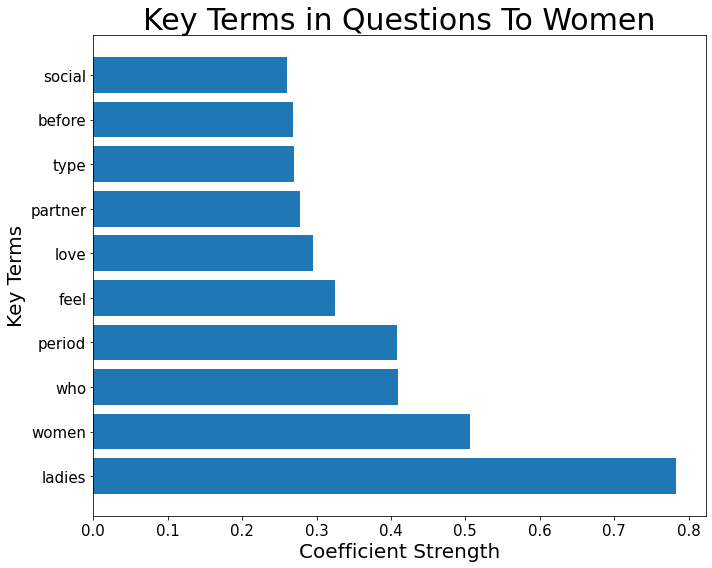

In [15]:
plt.figure(figsize = (10,8))
y_pos = np.arange(10)
plt.rc('axes', titlesize=30) 
plt.rc('axes', labelsize=20) 
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 
plt.barh(y_pos ,top_10_coefs['coefs'][:10])
plt.yticks(y_pos, top_10_coefs[:10].index)
plt.title('Key Terms in Questions To Women')
plt.xlabel('Coefficient Strength')
plt.ylabel('Key Terms')
plt.tight_layout()
plt.savefig('../Images/top_cofficient_coefs')

- For the terms ['ladies', 'women of', 'women who', 'women'] make sense. It is interesting to note that the word women is used instead of 'girl'
- Also interesting that the words 'love' and 'family' are found more in questions specified towards women

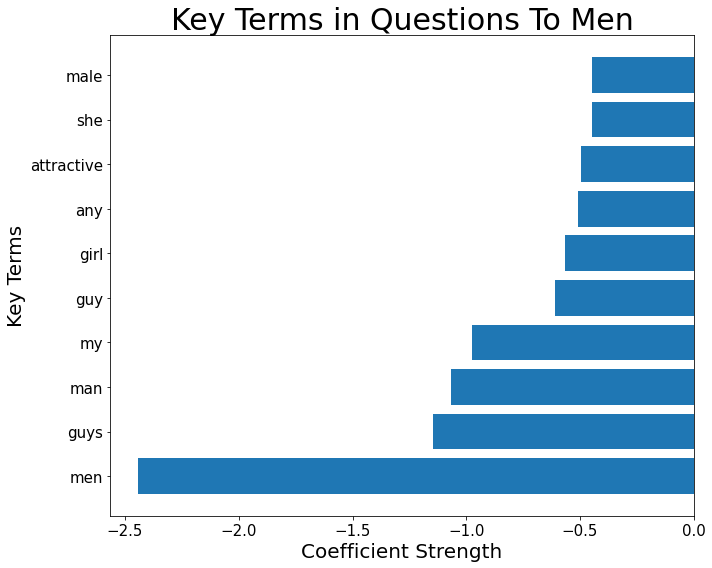

In [16]:
plt.figure(figsize = (10,8))
y_pos = np.arange(10)
plt.rc('axes', titlesize=30) 
plt.rc('axes', labelsize=20) 
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 
plt.barh(y_pos ,bot_10_coefs['coefs'][:10])
plt.yticks(y_pos, bot_10_coefs[:10].index)
plt.title('Key Terms in Questions To Men')
plt.xlabel('Coefficient Strength')
plt.ylabel('Key Terms')
plt.tight_layout()
plt.savefig('../Images/bot_cofficient_coefs')

- The terms ['men', 'guys', 'man', 'men of', 'guy', 'wife'] make sense in terms of questions geared towards men
- The use of 'my' however is interesting as it may pertain to how males refer to their partners when asking about them. Also the importance of the word 'attractive' is interesting to see.

---

# Classification Metrics

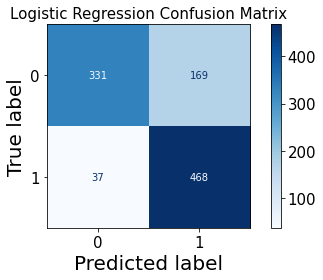

In [17]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, y_test, cmap='Blues')
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=10) 
plt.title('Logistic Regression Confusion Matrix')
plt.tight_layout()
plt.savefig('../Images/lgr_confusion_matrix.png');

In [18]:
print(f'Recall: {recall_score(y_test, preds)}')
print(f'Precision: {precision_score(y_test, preds)}')

Recall: 0.9267326732673268
Precision: 0.7346938775510204


---

# Looking at questions that were classified incorrectly

In [19]:
# Create DF of misclassified questions
test_questions = pd.DataFrame(preds, index=y_test.index, columns=['prediction'])
test_questions.shape

(1005, 1)

In [20]:
# Merging the predictions twith the questions they were related to

test_questions = test_questions.merge(df, left_on=test_questions.index, right_on = df.index)
test_questions.shape

(1005, 7)

In [21]:
test_questions.head()

,key_0,prediction,title,text,subreddit,title_length,text_length
0,xnkz15,1,has your bra clip ever opened accidentally in ...,,1,70,0
1,xrmtkh,1,would you care if your gf had bigger hands tha...,,0,68,0
2,xumabp,0,how to deal with dad who thinks your not good ...,my gf dad thinks she can do better than me i...,0,70,272
3,xn05d1,1,which movie character do you relate to the most,,0,48,0
4,xq4s0v,0,men of reddit what are three reasons you are ...,,0,75,0


In [22]:
# Filtered the misclassified questions by checking the prediction and the actual subreddit

misclassified = test_questions[test_questions['prediction'] != test_questions['subreddit']]
misclassified.shape

(206, 7)

In [23]:
misclassified.groupby(by = ['subreddit', 'prediction'])['subreddit'].value_counts()

subreddit  prediction  subreddit
0          1           0            169
1          0           1             37
Name: subreddit, dtype: int64

In [24]:
# Looking at the 30 top coefficients and combining them into a regex

top_15_coefs = coef_df.sort_values(by = 'coefs', ascending= False)[:15]
bot_15_coefs = coef_df.sort_values(by = 'coefs', ascending= True)[:15]
regex = '.*(' + '|'.join(top_15_coefs.index) + '|' + '|'.join(bot_15_coefs.index) + ').*'
regex

'.*(ladies|women|who|period|feel|love|partner|type|before|social|home|difference|an|about|person|men|guys|man|my|guy|girl|any|attractive|she|male|am|girlfriend|wife|makes|attracted).*'

In [25]:
# Creating lists of questions that have keywords in the top 15 or bot 15 coefficients

yes_key_word = misclassified[misclassified.title.str.match(regex)]

# Creating lists of questions that don't have keywords in the top 15 or bot 15 coefficients

no_key_words = misclassified.drop(yes_key_word.index)
print(yes_key_word.shape)
print(no_key_words.shape)

(143, 7)
(63, 7)


In [26]:
no_key_words[:20]

,key_0,prediction,title,text,subreddit,title_length,text_length
3,xn05d1,1,which movie character do you relate to the most,,0,48,0
22,xu1zlr,1,what is the most toxic thing you have willingl...,,0,66,0
26,xuzy8x,1,what s the worst job you ve ever worked,,0,40,0
27,xrgot6,1,what is a shallow reason that would make you e...,weight gain hair condition skin condition n...,0,64,69
56,xqq026,1,what are the best things you ve ever experienced,either physical or mental genuine question,0,49,44
61,xbqh67,0,it s almost spooky season what re you all goi...,,1,79,0
81,xpbkur,1,what kind of pressure do you experience from p...,,0,92,0
108,xv4dlk,1,why is it so hard to a beat porn addiction,,0,43,0
115,xejaje,0,for those of you that like the colour why pur...,for those of you that like the colour why pur...,1,50,99
139,xnwork,1,what s a household task most people hate but ...,mine is cutting the grass,0,63,25


After examining a few of the questions that don't contain any of the top 15 or bottom 15 key words that correlate to posts by women or men a lot of the questions are gender neutral, which not even an a person would be able to identify who the target is.

---

# Extra Models

---

# Second Model with Decision Trees

In [27]:
dt_pipe_params = {
    'cvec__max_features': range(3450,3500,10),
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2)],
    'est__min_samples_split': range(30,33,1),
    'est__min_samples_leaf': [1]
}

In [28]:
dt_gs = train_run_evaluate_grid_on_model(dt_pipe_params, DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

-----------------------------
Best Score: 0.7440246166730027
Best Params: {'cvec__max_features': 3470, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'est__min_samples_leaf': 1, 'est__min_samples_split': 30}
Training Accuracy: 0.9203187250996016
Testing  Accuracy: 0.7333333333333333


### OVERALL BEST PARAMETERS:

- cvec__max_features: 3450 - 3500
- cvec__ngram_range: (1,1)-(1,2)
- cvec__stop_words: None
- est__min_samples_leaf: 1
- est__min_samples_split:30-33

### Metrics

- Accuracy around 74-76%

In [29]:
dt_preds = dt_gs.predict(X_test)

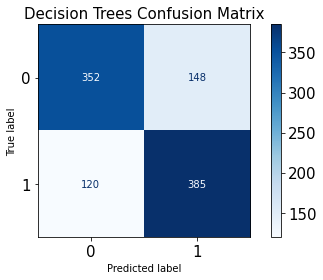

In [30]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(dt_gs, X_test, y_test, cmap='Blues')
plt.rc('axes', titlesize=15) 
plt.rc('axes', labelsize=10) 
plt.title('Decision Trees Confusion Matrix')
plt.tight_layout()
plt.savefig('../Images/dt_confusion_matrix.png');

In [31]:
print(f'Recall: {recall_score(y_test, dt_preds)}')
print(f'Precision: {precision_score(y_test, dt_preds)}')

Recall: 0.7623762376237624
Precision: 0.7223264540337712


- After optimizing on the parameters the Decision Tree performed worse in almost every category compared to the Logistic Regression model.
- There is a far lower recall score in comparison to the Logistic Regression model

---

# Third Model with RandomForest Classifier

In [32]:
rfc_pipe_params = {
    'cvec__max_features': range(3650, 3660,10),
    'cvec__stop_words': [None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'est__n_estimators':range(40, 46, 1),
    'est__min_samples_split': range(30,40,2),
    'est__min_samples_leaf': [1]
}

In [33]:
rf_gs = train_run_evaluate_grid_on_model(rfc_pipe_params, RandomForestClassifier(), X_train, X_test, y_train, y_test)

-----------------------------
Best Score: 0.7901748180470844
Best Params: {'cvec__max_features': 3650, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'est__min_samples_leaf': 1, 'est__min_samples_split': 32, 'est__n_estimators': 43}
Training Accuracy: 0.9455511288180611
Testing  Accuracy: 0.8059701492537313


### OVERALL BEST PARAMETERS:

- cvec__max_features: 3630 - 3650
- cvec__ngram_range: (1,1)-(1,2)
- cvec__stop_words: None
- est__min_samples_leaf: 1
- est__min_samples_split:38-40
- est__n_estimators: 40-45

### Metrics

- Max Accuracy: 80%

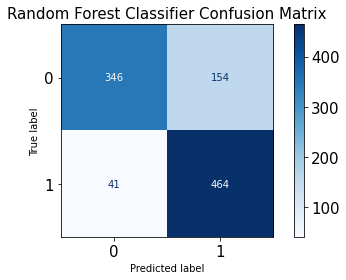

In [34]:
# Confusion matrix

ConfusionMatrixDisplay.from_estimator(rf_gs, X_test, y_test, cmap='Blues')
plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=10) 

plt.title('Random Forest Classifier Confusion Matrix')
plt.tight_layout()
plt.savefig('../Images/rfc_confusion_matrix.png');

In [35]:
rf_preds = rf_gs.predict(X_test)
print(f'Recall: {recall_score(y_test, rf_preds)}')
print(f'Precision: {precision_score(y_test, rf_preds)}')

Recall: 0.9188118811881189
Precision: 0.7508090614886731


- Althought this model had the highest metrics, since its an ensemble model it doesn't have the interpretability that DecisionTrees and Logistic Regression have. If the model had performed better by a sizeable amount there could have been consideration in using it over LogisticRegression.


---